In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
ROOT_PATH = "/Users/ArthurPech/documents/github/ml-foot/xpass-project"
import sys; sys.path
sys.path.append(ROOT_PATH)

# Imports

In [91]:
import os
import json
import pickle
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
import seaborn as sns

import shapely
from shapely import affinity

import dtale

from mplsoccer import Pitch

In [90]:
from scipy import stats

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import make_scorer, recall_score, precision_score, accuracy_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [5]:
from xpass.params import PROJECT_HOME, STATSBOMB_DATA, THREE_SIXTY, MATCHES, EVENTS, GENDER, SIZE, SIZE_MAP

In [6]:
from xpass.loading import *
from xpass.utils import *
from xpass.preprocessing import *

In [7]:
SIZE

'L'

# Load data

In [9]:
competitions = get_competitions()
competitions

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,43,106,International,FIFA World Cup,male,False,True,2022,2023-06-18T15:29:02.960922,2023-06-18T17:18:54.416705,2023-06-18T17:18:54.416705,2023-06-18T15:29:02.960922
1,11,90,Spain,La Liga,male,False,False,2020/2021,2022-12-05T14:39:07.366723,2023-04-28T08:23:01.474542,2023-04-28T08:23:01.474542,2022-12-05T14:39:07.366723
2,55,43,Europe,UEFA Euro,male,False,True,2020,2023-02-24T21:26:47.128979,2023-04-27T22:38:34.970148,2023-04-27T22:38:34.970148,2023-02-24T21:26:47.128979


In [10]:
matches = get_matches(competitions)
matches

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
0,3857256,2022-12-02,21:00:00.000,2,3,available,available,2023-02-17T23:45:15.306706,2023-04-26T23:49:58.956186,3,...,10,Group Stage,1001115,Stadium 974,185,Qatar,1121.0,Fernando Andrés Rapallini,11.0,Argentina
1,3869151,2022-12-03,21:00:00.000,2,1,available,available,2023-04-16T05:09:50.559670,2023-05-14T23:35:15.370647,4,...,33,Round of 16,1000793,Ahmad bin Ali Stadium,185,Qatar,367.0,Szymon Marciniak,182.0,Poland
2,3857257,2022-11-30,17:00:00.000,1,0,available,available,2023-04-28T17:13:10.958725,2023-04-28T17:16:11.332325,3,...,10,Group Stage,117897,Al Janoub Stadium,185,Qatar,2311.0,Mustapha Ghorbal,4.0,Algeria
3,3857258,2022-11-24,21:00:00.000,2,0,available,available,2023-04-01T16:33:02.950911,2023-05-30T15:21:09.388797,1,...,10,Group Stage,1001114,Lusail Stadium,185,Qatar,741.0,Alireza Faghani,107.0,"Iran, Islamic Republic of"
4,3857288,2022-11-26,12:00:00.000,0,1,available,available,2023-02-28T21:25:20.888552,2023-04-27T00:30:07.835815,2,...,10,Group Stage,117897,Al Janoub Stadium,185,Qatar,225.0,Daniel Siebert,85.0,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,3788742,2021-06-12,18:00:00.000,0,1,available,available,2021-06-14T12:52:32.995,2022-08-04T12:00,1,...,10,Group Stage,495,Parken,61,Denmark,8.0,Anthony Taylor,68.0,England
146,3788775,2021-06-23,18:00:00.000,0,5,available,available,2023-02-24T21:26:47.128979,2023-04-27T22:18:06.481826,3,...,10,Group Stage,117374,Estadio de La Cartuja,214,Spain,287.0,Björn Kuipers,160.0,Netherlands
147,3788776,2021-06-23,18:00:00.000,3,2,available,available,2021-06-24T15:06:44.531,2022-08-04T12:00,3,...,10,Group Stage,4726,Saint-Petersburg Stadium,188,Russia,1.0,Michael Oliver,68.0,England
148,3788743,2021-06-12,21:00:00.000,3,0,available,available,2022-12-01T16:08:33.870037,2023-04-27T22:37:57.086496,1,...,10,Group Stage,4726,Saint-Petersburg Stadium,188,Russia,180.0,Antonio Miguel Mateu Lahoz,214.0,Spain


In [11]:
frames, events = get_frames_and_events(matches)

/Users/ArthurPech/documents/github/ml-foot/xpass-project/xpass/loading.py:94: DtypeWarning:

Columns (17,68,72,79,84,92,93,94,96,97,98,99,100,101,102,103,105,106,112,113,115,116,118,119,120,121,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.



In [12]:
frames

,event_uuid,visible_area,freeze_frame
0,4acb4fd2-f46a-4d73-993c-e06597873924,"[18.8151432741548, 80.0, 44.7117185559985, 0.0...","[{'teammate': True, 'actor': False, 'keeper': ..."
1,b0d0583a-d544-4ab1-9043-6b42a57c27a8,"[16.2476193406485, 80.0, 43.2634196474088, 0.0...","[{'teammate': True, 'actor': False, 'keeper': ..."
2,0e5c867f-8c40-4754-bc81-014c8cf88b8d,"[16.2476193406485, 80.0, 43.2634196474088, 0.0...","[{'teammate': True, 'actor': False, 'keeper': ..."
3,f21fda3d-cb2c-4608-af2d-201d1ad8101c,"[11.5941753059148, 80.0, 40.9386188762705, 0.0...","[{'teammate': True, 'actor': False, 'keeper': ..."
4,c2ce6157-3b39-4a0e-b63f-3178874e1cf4,"[14.7823256671293, 80.0, 42.2276163973683, 4.4...","[{'teammate': True, 'actor': False, 'keeper': ..."
...,...,...,...
369302,5bfa0ed1-2d5f-449e-b571-8b20f637d84a,"[20.0624078964964, 80.0, 40.8523473197818, 4.4...","[{'teammate': True, 'actor': False, 'keeper': ..."
369303,7abc626d-c191-4f0d-9576-9e1c953cacc8,"[72.9496060165427, 80.0, 53.2416468459923, 80....","[{'teammate': True, 'actor': False, 'keeper': ..."
369304,5451bff1-7fa0-4c7a-b630-b580c30de610,"[40.1458057374461, 80.0, 13.5436695523849, 80....","[{'teammate': True, 'actor': False, 'keeper': ..."
369305,8955c5aa-8f0e-4b7b-ad2e-75505ddc1104,"[33.9496491770586, 80.0, 3.19071462800152, 80....","[{'teammate': False, 'actor': False, 'keeper':..."


In [13]:
events

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,goalkeeper_success_in_play,shot_redirect,goalkeeper_lost_in_play,goalkeeper_penalty_saved_to_post,player_off_permanent,match_date,competition_name,gender,home_team_name,away_team_name
0,093f898d-33b1-4425-b591-37dd9c9bf70b,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,2022-12-02,FIFA World Cup,male,Serbia,Switzerland
1,79a9efbb-b5e5-45b0-983d-8729bcc4a0e1,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,2022-12-02,FIFA World Cup,male,Serbia,Switzerland
2,c4cdfc71-b9f4-4751-a714-e816c1419457,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,2022-12-02,FIFA World Cup,male,Serbia,Switzerland
3,51f295b8-da96-428e-ab47-90f380f8cf53,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,2022-12-02,FIFA World Cup,male,Serbia,Switzerland
4,4acb4fd2-f46a-4d73-993c-e06597873924,5,1,00:00:00.521,0,0,2,1.220932,30,Pass,...,NaN,NaN,NaN,NaN,NaN,2022-12-02,FIFA World Cup,male,Serbia,Switzerland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427317,5a249e6d-5d14-4bdb-b109-28f1c94f0e58,2993,2,00:50:23.150,95,23,151,0.870930,30,Pass,...,NaN,NaN,NaN,NaN,NaN,2021-06-12,UEFA Euro,male,Wales,Switzerland
427318,e5bcdd2d-c9cf-488b-b04e-d8166141e905,2994,2,00:50:24.021,95,24,151,NaN,42,Ball Receipt*,...,NaN,NaN,NaN,NaN,NaN,2021-06-12,UEFA Euro,male,Wales,Switzerland
427319,d0eb2962-e35d-4ea4-a302-2c4e7aa79122,2995,2,00:50:24.021,95,24,151,0.000000,10,Interception,...,NaN,NaN,NaN,NaN,NaN,2021-06-12,UEFA Euro,male,Wales,Switzerland
427320,4c95462b-e1e5-47a5-9487-8793d3ef1353,2996,2,00:50:25.404,95,25,151,0.000000,34,Half End,...,NaN,NaN,NaN,NaN,NaN,2021-06-12,UEFA Euro,male,Wales,Switzerland


In [14]:
passes = get_passes(events, frames)

In [20]:
passes.head(3)

,id,match_date,competition_name,gender,home_team_name,away_team_name,index,period,timestamp,minute,...,pass_goal_assist,pass_through_ball,pass_miscommunication,match_id,pass_no_touch,pass_straight,pass_inswinging,event_uuid,visible_area,freeze_frame
0,4acb4fd2-f46a-4d73-993c-e06597873924,2022-12-02,FIFA World Cup,male,Serbia,Switzerland,5,1,00:00:00.521,0,...,NaN,NaN,NaN,3857256,NaN,NaN,NaN,4acb4fd2-f46a-4d73-993c-e06597873924,"[18.8151432741548, 80.0, 44.7117185559985, 0.0...","[{'teammate': True, 'actor': False, 'keeper': ..."
1,f21fda3d-cb2c-4608-af2d-201d1ad8101c,2022-12-02,FIFA World Cup,male,Serbia,Switzerland,8,1,00:00:03.385,0,...,NaN,NaN,NaN,3857256,NaN,NaN,NaN,f21fda3d-cb2c-4608-af2d-201d1ad8101c,"[11.5941753059148, 80.0, 40.9386188762705, 0.0...","[{'teammate': True, 'actor': False, 'keeper': ..."
2,57654ce3-e311-49c4-9ba7-4fab2ec66f71,2022-12-02,FIFA World Cup,male,Serbia,Switzerland,11,1,00:00:06.697,0,...,NaN,NaN,NaN,3857256,NaN,NaN,NaN,57654ce3-e311-49c4-9ba7-4fab2ec66f71,"[14.3417879978964, 80.0, 41.1178341482568, 9.0...","[{'teammate': True, 'actor': False, 'keeper': ..."


In [21]:
passes.shape

(102661, 64)

In [22]:
passes.columns

Index(['id', 'match_date', 'competition_name', 'gender', 'home_team_name',
       'away_team_name', 'index', 'period', 'timestamp', 'minute', 'second',
       'possession', 'duration', 'type_id', 'type_name', 'possession_team_id',
       'possession_team_name', 'play_pattern_id', 'play_pattern_name',
       'team_id', 'team_name', 'related_events', 'location', 'player_id',
       'player_name', 'position_id', 'position_name', 'pass_recipient_id',
       'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id',
       'pass_height_name', 'pass_end_location', 'pass_body_part_id',
       'pass_body_part_name', 'pass_type_id', 'pass_type_name', 'pass_cross',
       'pass_outcome_id', 'pass_outcome_name', 'under_pressure',
       'pass_assisted_shot_id', 'pass_shot_assist', 'off_camera',
       'pass_deflected', 'counterpress', 'pass_aerial_won', 'pass_switch',
       'out', 'pass_outswinging', 'pass_technique_id', 'pass_technique_name',
       'pass_cut_back', 'pass_goal_assist

In [24]:
passes["pass_outcome_name"].isna().sum()

85779

In [23]:
passes["pass_outcome_name"].value_counts()

Incomplete      14929
Out              1612
Pass Offside      341
Name: pass_outcome_name, dtype: int64

# Split the dataset

In [31]:
train, test, calibration, demo = split_dataset(
    passes, test_size = 0.1, calibration_size = 0.1, demo_size = 0.05)

In [32]:
train.shape, test.shape, calibration.shape, demo.shape

((76994, 64), (10267, 64), (10266, 64), (5134, 64))

In [33]:
# Preprocessed data 
train_preprocessed = get_passes_preprocessed(train, balance_ratio = 1, dataset = "train")
test_preprocessed = get_passes_preprocessed(test, dataset = "test")
calibration_preprocessed = get_passes_preprocessed(calibration, dataset = "calibration")
demo_preprocessed = get_passes_preprocessed(demo, dataset = "demo")

Balancing the data with a ratio of 1 between successful and unsuccessful passes...
Data was correctly balanced.


In [34]:
train_preprocessed.shape, test_preprocessed.shape, calibration_preprocessed.shape, demo_preprocessed.shape

((25446, 8), (10267, 8), (10266, 8), (5134, 8))

In [35]:
train_preprocessed["success"].value_counts()

1    12723
0    12723
Name: success, dtype: int64

In [36]:
X_train = train_preprocessed.drop(columns = ["success"])
y_train = train_preprocessed["success"]

X_test = test_preprocessed.drop(columns = ["success"])
y_test = test_preprocessed["success"]

In [37]:
X_train.head(2)

,location_x,location_y,play_pattern_name,pass_angle,pass_height_id,pass_body_part_name,freeze_frame
1911,30.9,27.3,From Throw In,1.411058,1.0,Right Foot,"[{'teammate': True, 'actor': False, 'keeper': ..."
90073,113.4,56.5,Regular Play,-1.591202,2.0,Left Foot,"[{'teammate': False, 'actor': False, 'keeper':..."


In [38]:
y_train.head(2)

1911     1
90073    0
Name: success, dtype: int64

# Preprocessing

In [39]:
pipeline

Pipeline(steps=[('receptiontransformer', ReceptionTransformer()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13176d900>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13176d9f0>)]))])

In [40]:
X_train_scaled = pipeline.fit_transform(X_train)

In [41]:
X_train_scaled

array([[0.2556391 , 0.34042553, 0.72428331, ..., 0.        , 0.        ,
        1.        ],
       [0.94486216, 0.70588235, 0.24594967, ..., 0.        , 0.        ,
        0.        ],
       [0.80701754, 0.52315394, 0.41827661, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07101086, 0.6620776 , 0.63249773, ..., 0.        , 0.        ,
        1.        ],
       [0.32163743, 0.50312891, 0.62069135, ..., 0.        , 0.        ,
        0.        ],
       [0.21470343, 0.81602003, 0.63755376, ..., 0.        , 0.        ,
        0.        ]])

# Plot a demo pass

In [67]:
pass_row = demo.sample(1).iloc[0]

In [75]:
pd.DataFrame(pass_row).head(11)

,75456
id,58aa4893-a9dd-4d3d-9bca-9b73f3dee882
match_date,2021-06-23
competition_name,UEFA Euro
gender,male
home_team_name,Portugal
away_team_name,France
index,878
period,1
timestamp,00:15:57.940
minute,15


In [69]:
pass_row["pass_outcome_name"]

'Incomplete'

<AxesSubplot:xlabel='x', ylabel='y'>

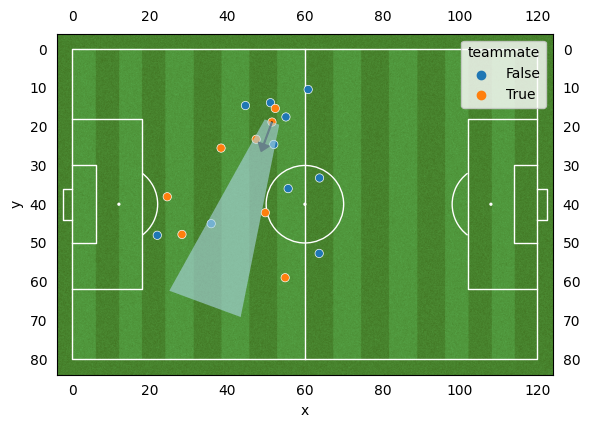

In [70]:
plot_pass(pass_row)

<AxesSubplot:xlabel='x', ylabel='y'>

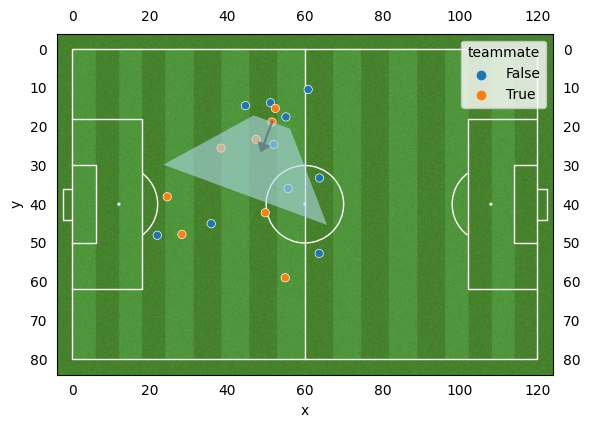

In [71]:
plot_pass(pass_row, corr_width = 5, length = 20, alpha = 45)

# Model

## Base model

In [76]:
base_model = make_pipeline(pipeline, LogisticRegression())
base_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('receptiontransformer',
                                  ReceptionTransformer()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d900>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d9f0>)]))])),
                ('logisticregression', LogisticRegression())])

In [77]:
cv_results = cross_validate(base_model, X_train, y_train, cv = 5,
                            scoring = ["accuracy", "recall", "precision", "f1"])

In [78]:
cv_results

{'fit_time': array([55.50538993, 58.5635159 , 53.02964997, 53.01810598, 52.10819602]),
 'score_time': array([12.88105893, 13.61617088, 14.15460873, 13.23194289, 13.61402702]),
 'test_accuracy': array([0.78939096, 0.78954608, 0.79033209, 0.7909216 , 0.79740617]),
 'test_recall': array([0.83222004, 0.82082515, 0.82868369, 0.83097484, 0.83018868]),
 'test_precision': array([0.76655809, 0.77255917, 0.76970803, 0.76928675, 0.77904832]),
 'test_f1': array([0.79804069, 0.79596114, 0.79810785, 0.7989418 , 0.8038059 ])}

In [79]:
base_model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('receptiontransformer',
                                  ReceptionTransformer()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d900>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d9f0>)]))])),
                ('logisticregression', LogisticRegression())])

In [80]:
y_pred = base_model.predict(X_test)
y_probas = base_model.predict_proba(X_test)

In [81]:
cf_matrix = confusion_matrix(y_pred, y_test)
cf_matrix

array([[1298, 1461],
       [ 397, 7111]])

In [82]:
recall_0 = recall_score(y_test, y_pred, pos_label = 0)
recall_1 = recall_score(y_test, y_pred, pos_label = 1)
precision_0 = precision_score(y_test, y_pred, pos_label = 0)
precision_1 = precision_score(y_test, y_pred, pos_label = 1)

result = {
    "recall" : {0 : recall_0, 1 : recall_1},
    "precision" : {0 : precision_0, 1 : precision_1}
    }

pd.DataFrame.from_dict(result)

,recall,precision
0,0.765782,0.470460
1,0.829561,0.947123


## xpass on a sample demo pass

In [83]:
sample_demo_pass = demo.sample(1)
sample_demo_pass

,id,match_date,competition_name,gender,home_team_name,away_team_name,index,period,timestamp,minute,...,pass_goal_assist,pass_through_ball,pass_miscommunication,match_id,pass_no_touch,pass_straight,pass_inswinging,event_uuid,visible_area,freeze_frame
120538,1097884c-3d5d-45d1-b063-d9421e405837,2021-06-23,UEFA Euro,male,Sweden,Poland,313,1,00:08:34.895,8,...,NaN,NaN,NaN,3788776,NaN,NaN,NaN,1097884c-3d5d-45d1-b063-d9421e405837,"[101.490962622043, 64.1480919032825, 73.442067...","[{'teammate': True, 'actor': False, 'keeper': ..."


<AxesSubplot:xlabel='x', ylabel='y'>

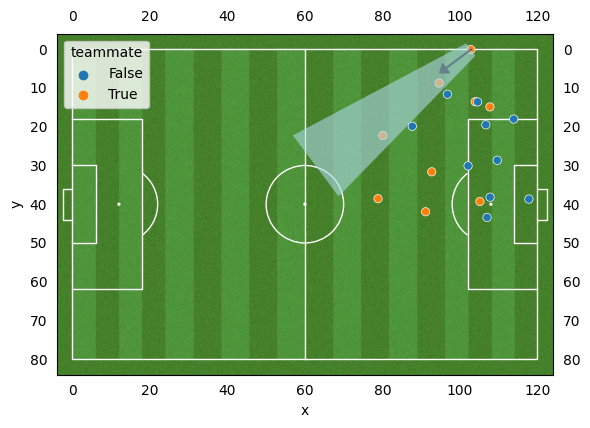

In [84]:
plot_pass(sample_demo_pass.iloc[0])

In [85]:
sample_demo_pass_preprocessed = get_passes_preprocessed(sample_demo_pass)
sample_demo_pass_preprocessed

,location_x,location_y,play_pattern_name,pass_angle,pass_height_id,pass_body_part_name,freeze_frame,success
120538,102.8,0.1,From Throw In,2.498092,2.0,NaN,"[{'teammate': True, 'actor': False, 'keeper': ...",1


In [86]:
base_model.predict(sample_demo_pass_preprocessed)

array([1])

In [87]:
base_model.predict_proba(sample_demo_pass_preprocessed)

array([[0.20925435, 0.79074565]])

## GridSearch a base model

In [92]:
base_results = []

base_models = [
    LogisticRegression(),
    # SVC(), # takes long
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    BaggingClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

for base_model in base_models:

    print(f"-- Instantiate and fit model : {base_model} --")
    model = make_pipeline(pipeline, base_model)
    model_name = model.steps[-1][0]
    t0 = time()
    model.fit(X_train, y_train)
    t1 = time() - t0
    
    print("--- Predict ---")
    y_pred = model.predict(X_test)
    # y_probas = model.predict_proba(X_test)
    
    print("--- Evaluate ---")
    accuracy = accuracy_score(y_test, y_pred)
    f1_0 = f1_score(y_test, y_pred, pos_label = 0)
    f1_1 = f1_score(y_test, y_pred, pos_label = 1)
    recall_0 = recall_score(y_test, y_pred, pos_label = 0)
    recall_1 = recall_score(y_test, y_pred, pos_label = 1)
    precision_0 = precision_score(y_test, y_pred, pos_label = 0)
    precision_1 = precision_score(y_test, y_pred, pos_label = 1)
    
    results = {
        "model" : model_name,
        "accuracy" : accuracy,
        "f1_0" : f1_0,
        "f1_1" : f1_1,
        "recall_0" : recall_0,
        "recall_1" : recall_1,
        "precision_0" : precision_0,
        "precision_1" : precision_1,
        "training_time" : t1
    }
    
    base_results.append(results)
    

-- Instantiate and fit model : LogisticRegression() --
--- Predict ---
--- Evaluate ---
-- Instantiate and fit model : DecisionTreeClassifier() --
--- Predict ---
--- Evaluate ---
-- Instantiate and fit model : RandomForestClassifier() --
--- Predict ---
--- Evaluate ---
-- Instantiate and fit model : BaggingClassifier() --
--- Predict ---
--- Evaluate ---
-- Instantiate and fit model : AdaBoostClassifier() --
--- Predict ---
--- Evaluate ---
-- Instantiate and fit model : GradientBoostingClassifier() --
--- Predict ---
--- Evaluate ---


In [93]:
pd.DataFrame.from_dict(base_results).sort_values(by = ["accuracy", "recall_0"], ascending = False)

,model,accuracy,f1_0,f1_1,recall_0,recall_1,precision_0,precision_1,training_time
0,logisticregression,0.819032,0.582847,0.884453,0.765782,0.829561,0.470460,0.947123,95.995746
5,gradientboostingclassifier,0.816305,0.601605,0.880633,0.840118,0.811596,0.468575,0.962507,78.234277
4,adaboostclassifier,0.810071,0.592902,0.876143,0.837758,0.804596,0.458805,0.961656,113.301867
2,randomforestclassifier,0.808318,0.596059,0.874346,0.856637,0.798763,0.457035,0.965726,105.458448
3,baggingclassifier,0.775884,0.554846,0.850244,0.846018,0.762016,0.412781,0.961578,82.255324
1,decisiontreeclassifier,0.760884,0.511831,0.841664,0.759292,0.761199,0.386023,0.941151,107.305466


# GridSearch hyperparameters of the best base model

In [94]:
all_results = base_results.copy()

## Gradient Boosting

In [95]:
gb_model = make_pipeline(pipeline, GradientBoostingClassifier())
gb_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('receptiontransformer',
                                  ReceptionTransformer()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d900>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d9f0>)]))])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [96]:
scorers = {
    "accuracy" : make_scorer(accuracy_score),
    "f1_0" : make_scorer(f1_score, pos_label = 0),
    "f1_1" : make_scorer(f1_score, pos_label = 1),
    "recall_0" : make_scorer(recall_score, pos_label = 0),
    "recall_1" : make_scorer(recall_score, pos_label = 1),
    "precision_0" : make_scorer(precision_score, pos_label = 0),
    "precision_1" : make_scorer(precision_score, pos_label = 1)
}

In [97]:
gb_model.steps[-1][0]

'gradientboostingclassifier'

In [98]:
n_iter = 10
model_name = gb_model.steps[-1][0]

gb_grid = {
    f"{model_name}__n_estimators" : stats.randint(50, 150),
    f"{model_name}__learning_rate" : stats.uniform(0, 0.2),
    f"{model_name}__min_samples_split" : stats.randint(2, 5),
    f"{model_name}__min_samples_leaf" : stats.randint(1, 5)
}

gb_search = RandomizedSearchCV(
    gb_model,
    gb_grid, 
    scoring = scorers,
    refit = "accuracy",
    cv = 5,
    n_iter = n_iter,
    n_jobs = -1, # parallelize computation,
    verbose = 2
)

gb_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END gradientboostingclassifier__learning_rate=0.07356589840601523, gradientboostingclassifier__min_samples_leaf=4, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=83; total time= 4.1min
[CV] END gradientboostingclassifier__learning_rate=0.010382311227689067, gradientboostingclassifier__min_samples_leaf=1, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=60; total time= 5.0min
[CV] END gradientboostingclassifier__learning_rate=0.12318316816928208, gradientboostingclassifier__min_samples_leaf=3, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=121; total time= 4.8min
[CV] END gradientboostingclassifier__learning_rate=0.12318316816928208, gradientboostingclassifier__min_samples_leaf=3, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=121; total time=11.5min
[CV]

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('receptiontransformer',
                                                               ReceptionTransformer()),
                                                              ('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer()),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x13176d...
                   refit='accuracy',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1_0': make_scorer(f1_score, pos_label=0),
                            'f1_1': make_scorer(f1_score, pos_label=1),
                            'precision_0': make_scorer(precision_score, pos_label=0),
                            'precision_1': make_scorer(precision_score, pos_label=1),
                            'recall_0': make_scorer(recall_score, pos_label=0),
                            'recall_1': make_scorer(recall_score, pos_label=1)},
                   verbose=2)

In [99]:
gb_search.cv_results_

{'mean_fit_time': array([187.73366189, 222.15537934, 418.41691837, 396.27994566,
        331.28773475, 279.00732059, 251.86165748, 287.57651052,
        291.20561805, 291.01990623]),
 'std_fit_time': array([ 15.50528947,   5.70984197, 147.82173864,  70.8913641 ,
         10.64560269,  61.05636062,  35.71730156,   6.41670768,
          2.19832936,  30.36787757]),
 'mean_score_time': array([ 69.89062142,  67.71560545, 106.81541348,  79.58730211,
         92.21891141,  45.06358528,  69.00614166,  68.27587938,
         61.6606554 ,  53.34076543]),
 'std_score_time': array([ 7.06359534, 19.43470289, 41.84245845, 29.41564981, 23.55960874,
         2.45401174, 20.09730237, 12.95879707,  6.35563228,  9.80544407]),
 'param_gradientboostingclassifier__learning_rate': masked_array(data=[0.07356589840601523, 0.010382311227689067,
                    0.12318316816928208, 0.022103892171613307,
                    0.19674932909670384, 0.17898109878986634,
                    0.16345139355047555, 0.15

In [100]:
for i in range(n_iter):
    
    metrics = {m : gb_search.cv_results_[f"mean_test_{m}"][i] for m in scorers.keys()}

    results = {
        "model" : model_name,
        "training_time" : gb_search.cv_results_["mean_fit_time"][i]
        }
        
    results = dict(results, **metrics, **gb_search.cv_results_["params"][i])
    
    all_results.append(results)

In [101]:
results_df = pd.DataFrame.from_dict(all_results).sort_values(by = ["recall_0"], ascending = False)
results_df

,model,accuracy,f1_0,f1_1,recall_0,recall_1,precision_0,precision_1,training_time,gradientboostingclassifier__learning_rate,gradientboostingclassifier__min_samples_leaf,gradientboostingclassifier__min_samples_split,gradientboostingclassifier__n_estimators
2,randomforestclassifier,0.808318,0.596059,0.874346,0.856637,0.798763,0.457035,0.965726,105.458448,NaN,NaN,NaN,NaN
3,baggingclassifier,0.775884,0.554846,0.850244,0.846018,0.762016,0.412781,0.961578,82.255324,NaN,NaN,NaN,NaN
5,gradientboostingclassifier,0.816305,0.601605,0.880633,0.840118,0.811596,0.468575,0.962507,78.234277,NaN,NaN,NaN,NaN
4,adaboostclassifier,0.810071,0.592902,0.876143,0.837758,0.804596,0.458805,0.961656,113.301867,NaN,NaN,NaN,NaN
10,gradientboostingclassifier,0.820051,0.822761,0.817245,0.835417,0.804685,0.810528,0.830256,331.287735,0.196749,1.0,2.0,136.0
13,gradientboostingclassifier,0.820915,0.823329,0.818427,0.834631,0.807201,0.812362,0.830007,287.576511,0.150228,4.0,2.0,76.0
11,gradientboostingclassifier,0.820286,0.822777,0.817715,0.834317,0.806258,0.811598,0.829555,279.007321,0.178981,2.0,3.0,78.0
8,gradientboostingclassifier,0.819736,0.822244,0.817142,0.833845,0.805629,0.811023,0.829062,418.416918,0.123183,3.0,4.0,121.0
12,gradientboostingclassifier,0.820090,0.822360,0.817751,0.832902,0.807280,0.812127,0.828551,251.861657,0.163451,4.0,4.0,79.0
15,gradientboostingclassifier,0.817929,0.820413,0.815359,0.831802,0.804057,0.809395,0.827056,291.019906,0.052914,4.0,4.0,128.0


In [102]:
results_df.to_csv("models_info.csv", index = False)

## Random Forrest

In [103]:
rf_model = make_pipeline(pipeline, RandomForestClassifier())
rf_model

[CV] END gradientboostingclassifier__learning_rate=0.07356589840601523, gradientboostingclassifier__min_samples_leaf=4, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=83; total time= 4.1min
[CV] END gradientboostingclassifier__learning_rate=0.07356589840601523, gradientboostingclassifier__min_samples_leaf=4, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=83; total time= 5.0min
[CV] END gradientboostingclassifier__learning_rate=0.010382311227689067, gradientboostingclassifier__min_samples_leaf=1, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=60; total time= 4.6min
[CV] END gradientboostingclassifier__learning_rate=0.12318316816928208, gradientboostingclassifier__min_samples_leaf=3, gradientboostingclassifier__min_samples_split=4, gradientboostingclassifier__n_estimators=121; total time=11.3min
[CV] END gradientboostingclassifier__learning_rate=0.0221038921716

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('receptiontransformer',
                                  ReceptionTransformer()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d900>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d9f0>)]))])),
                ('randomforestclassifier', RandomForestClassifier())])

In [104]:
n_iter = 10
model_name = rf_model.steps[-1][0]

rf_grid = {
    f"{model_name}__n_estimators" : stats.randint(10, 200),
    f"{model_name}__max_depth" : stats.randint(2, 20),
    f"{model_name}__min_samples_split" : stats.randint(2, 5),
    f"{model_name}__min_samples_leaf" : stats.randint(1, 10)
}

rf_search = RandomizedSearchCV(
    rf_model,
    rf_grid, 
    scoring = scorers,
    refit = "accuracy",
    cv = 5,
    n_iter = n_iter,
    n_jobs = -1, # parallelize computation,
    verbose = 2
)

rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('receptiontransformer',
                                                               ReceptionTransformer()),
                                                              ('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer()),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x13176d...
                   refit='accuracy',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1_0': make_scorer(f1_score, pos_label=0),
                            'f1_1': make_scorer(f1_score, pos_label=1),
                            'precision_0': make_scorer(precision_score, pos_label=0),
                            'precision_1': make_scorer(precision_score, pos_label=1),
                            'recall_0': make_scorer(recall_score, pos_label=0),
                            'recall_1': make_scorer(recall_score, pos_label=1)},
                   verbose=2)

[CV] END randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100; total time= 6.1min
[CV] END randomforestclassifier__max_depth=17, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=189; total time= 5.6min
[CV] END randomforestclassifier__max_depth=17, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=189; total time= 2.3min
[CV] END randomforestclassifier__max_depth=11, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=116; total time= 2.2min
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=13; total time= 2.1min
[CV] END randomfo

[CV] END randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=9, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=100; total time= 6.1min
[CV] END randomforestclassifier__max_depth=17, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=4, randomforestclassifier__n_estimators=189; total time= 5.6min
[CV] END randomforestclassifier__max_depth=11, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=116; total time= 2.3min
[CV] END randomforestclassifier__max_depth=11, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=116; total time= 2.2min
[CV] END randomforestclassifier__max_depth=5, randomforestclassifier__min_samples_leaf=6, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=13; total time= 2.1min
[CV] END randomfo

In [105]:
rf_search.cv_results_

{'mean_fit_time': array([274.27187724, 230.67047215, 107.78138928, 100.28967414,
        104.23892756, 104.5587564 , 134.91247826, 200.74636846,
        248.5781508 , 182.24318261]),
 'std_fit_time': array([27.96058805, 96.72277764,  1.33484975,  1.88290062,  1.40989193,
         0.49987407, 24.33881904, 20.22113586, 25.04475008, 90.6928982 ]),
 'mean_score_time': array([88.80047774, 26.54958673, 25.8526072 , 25.64865818, 25.51028924,
        25.60762796, 48.81632586, 49.37185292, 83.07803898, 23.39153838]),
 'std_score_time': array([31.87952392,  0.41293394,  0.72016258,  0.2357673 ,  0.9577711 ,
         0.34280087, 16.8450694 ,  9.83673378, 17.45775248,  8.65320607]),
 'param_randomforestclassifier__max_depth': masked_array(data=[12, 17, 11, 5, 10, 5, 17, 11, 4, 6],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_randomforestclassifier__min_samples_leaf': masked

In [106]:
for i in range(n_iter):
    
    metrics = {m : rf_search.cv_results_[f"mean_test_{m}"][i] for m in scorers.keys()}

    results = {
        "model" : model_name,
        "training_time" : rf_search.cv_results_["mean_fit_time"][i]
        }
        
    results = dict(results, **metrics, **rf_search.cv_results_["params"][i])
    
    all_results.append(results)

In [108]:
results_df = pd.DataFrame.from_dict(all_results).sort_values(by = ["accuracy", "recall_0"], ascending = False)
results_df

,model,accuracy,f1_0,f1_1,recall_0,recall_1,precision_0,precision_1,training_time,gradientboostingclassifier__learning_rate,gradientboostingclassifier__min_samples_leaf,gradientboostingclassifier__min_samples_split,gradientboostingclassifier__n_estimators,randomforestclassifier__max_depth,randomforestclassifier__min_samples_leaf,randomforestclassifier__min_samples_split,randomforestclassifier__n_estimators
13,gradientboostingclassifier,0.820915,0.823329,0.818427,0.834631,0.807201,0.812362,0.830007,287.576511,0.150228,4.0,2.0,76.0,NaN,NaN,NaN,NaN
11,gradientboostingclassifier,0.820286,0.822777,0.817715,0.834317,0.806258,0.811598,0.829555,279.007321,0.178981,2.0,3.0,78.0,NaN,NaN,NaN,NaN
12,gradientboostingclassifier,0.820090,0.822360,0.817751,0.832902,0.807280,0.812127,0.828551,251.861657,0.163451,4.0,4.0,79.0,NaN,NaN,NaN,NaN
22,randomforestclassifier,0.820090,0.823101,0.816962,0.837146,0.803035,0.809571,0.831443,134.912478,NaN,NaN,NaN,NaN,17.0,8.0,2.0,173.0
10,gradientboostingclassifier,0.820051,0.822761,0.817245,0.835417,0.804685,0.810528,0.830256,331.287735,0.196749,1.0,2.0,136.0,NaN,NaN,NaN,NaN
17,randomforestclassifier,0.819894,0.822881,0.816782,0.836832,0.802957,0.809475,0.831199,230.670472,NaN,NaN,NaN,NaN,17.0,6.0,4.0,189.0
8,gradientboostingclassifier,0.819736,0.822244,0.817142,0.833845,0.805629,0.811023,0.829062,418.416918,0.123183,3.0,4.0,121.0,NaN,NaN,NaN,NaN
18,randomforestclassifier,0.819736,0.822378,0.817001,0.834631,0.804843,0.810534,0.829596,107.781389,NaN,NaN,NaN,NaN,11.0,2.0,2.0,116.0
0,logisticregression,0.819032,0.582847,0.884453,0.765782,0.829561,0.470460,0.947123,95.995746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,randomforestclassifier,0.818911,0.821541,0.816186,0.833688,0.804136,0.809813,0.828686,104.238928,NaN,NaN,NaN,NaN,10.0,1.0,2.0,88.0


## Logistic Regression

In [111]:
lr_model = make_pipeline(pipeline, LogisticRegression())
lr_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('receptiontransformer',
                                  ReceptionTransformer()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d900>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x13176d9f0>)]))])),
                ('logisticregression', LogisticRegression())])

In [112]:
n_iter = 10
model_name = lr_model.steps[-1][0]

lr_grid = [
    {
        f"{model_name}__penalty" : ["l1"],
        f"{model_name}__C" : [0.001, 0.01, 0.1, 1, 10],
        f"{model_name}__solver": ["liblinear", "saga"],
        f"{model_name}__max_iter": [100, 200, 1000]
    },
    {
        f"{model_name}__penalty" : ["l2"],
        f"{model_name}__C" : [0.001, 0.01, 0.1, 1, 10],
        f"{model_name}__solver": ["liblinear", "sag", "lbfgs"],
        f"{model_name}__max_iter": [100, 200, 1000]
    }
]

lr_search = RandomizedSearchCV(
    lr_model,
    lr_grid, 
    scoring = scorers,
    refit = "accuracy",
    cv = 5,
    n_iter = n_iter,
    n_jobs = -1, # parallelize computation,
    verbose = 2
)

lr_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('receptiontransformer',
                                                               ReceptionTransformer()),
                                                              ('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer()),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x13176d...
                   refit='accuracy',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1_0': make_scorer(f1_score, pos_label=0),
                            'f1_1': make_scorer(f1_score, pos_label=1),
                            'precision_0': make_scorer(precision_score, pos_label=0),
                            'precision_1': make_scorer(precision_score, pos_label=1),
                            'recall_0': make_scorer(recall_score, pos_label=0),
                            'recall_1': make_scorer(recall_score, pos_label=1)},
                   verbose=2)

In [113]:
for i in range(n_iter):
    
    metrics = {m : lr_search.cv_results_[f"mean_test_{m}"][i] for m in scorers.keys()}

    results = {
        "model" : model_name,
        "training_time" : lr_search.cv_results_["mean_fit_time"][i]
        }
        
    results = dict(results, **metrics, **lr_search.cv_results_["params"][i])
    
    all_results.append(results)

In [114]:
results_df = pd.DataFrame.from_dict(all_results).sort_values(by = ["accuracy", "recall_0"], ascending = False)
results_df

,model,accuracy,f1_0,f1_1,recall_0,recall_1,precision_0,precision_1,training_time,gradientboostingclassifier__learning_rate,...,gradientboostingclassifier__min_samples_split,gradientboostingclassifier__n_estimators,randomforestclassifier__max_depth,randomforestclassifier__min_samples_leaf,randomforestclassifier__min_samples_split,randomforestclassifier__n_estimators,logisticregression__solver,logisticregression__penalty,logisticregression__max_iter,logisticregression__C
13,gradientboostingclassifier,0.820915,0.823329,0.818427,0.834631,0.807201,0.812362,0.830007,287.576511,0.150228,...,2.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,gradientboostingclassifier,0.820286,0.822777,0.817715,0.834317,0.806258,0.811598,0.829555,279.007321,0.178981,...,3.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,gradientboostingclassifier,0.820090,0.822360,0.817751,0.832902,0.807280,0.812127,0.828551,251.861657,0.163451,...,4.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,randomforestclassifier,0.820090,0.823101,0.816962,0.837146,0.803035,0.809571,0.831443,134.912478,NaN,...,NaN,NaN,17.0,8.0,2.0,173.0,NaN,NaN,NaN,NaN
10,gradientboostingclassifier,0.820051,0.822761,0.817245,0.835417,0.804685,0.810528,0.830256,331.287735,0.196749,...,2.0,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,randomforestclassifier,0.819894,0.822881,0.816782,0.836832,0.802957,0.809475,0.831199,230.670472,NaN,...,NaN,NaN,17.0,6.0,4.0,189.0,NaN,NaN,NaN,NaN
8,gradientboostingclassifier,0.819736,0.822244,0.817142,0.833845,0.805629,0.811023,0.829062,418.416918,0.123183,...,4.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,randomforestclassifier,0.819736,0.822378,0.817001,0.834631,0.804843,0.810534,0.829596,107.781389,NaN,...,NaN,NaN,11.0,2.0,2.0,116.0,NaN,NaN,NaN,NaN
0,logisticregression,0.819032,0.582847,0.884453,0.765782,0.829561,0.470460,0.947123,95.995746,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,randomforestclassifier,0.818911,0.821541,0.816186,0.833688,0.804136,0.809813,0.828686,104.238928,NaN,...,NaN,NaN,10.0,1.0,2.0,88.0,NaN,NaN,NaN,NaN


## Save best models params

In [115]:
filename = f"best_params_{SIZE}.csv"
filepath = os.path.join(PROJECT_HOME, "data", "best_params", filename)
results_df.to_csv(filepath, index = False)

[CV] END logisticregression__C=0.1, logisticregression__max_iter=200, logisticregression__penalty=l2, logisticregression__solver=liblinear; total time= 3.4min
[CV] END logisticregression__C=0.001, logisticregression__max_iter=100, logisticregression__penalty=l2, logisticregression__solver=lbfgs; total time= 2.1min
[CV] END logisticregression__C=0.01, logisticregression__max_iter=100, logisticregression__penalty=l2, logisticregression__solver=liblinear; total time= 2.3min
[CV] END logisticregression__C=0.01, logisticregression__max_iter=100, logisticregression__penalty=l2, logisticregression__solver=liblinear; total time= 3.9min
[CV] END logisticregression__C=1, logisticregression__max_iter=1000, logisticregression__penalty=l1, logisticregression__solver=saga; total time= 4.3min
[CV] END logisticregression__C=0.1, logisticregression__max_iter=100, logisticregression__penalty=l2, logisticregression__solver=sag; total time= 3.8min
[CV] END logisticregression__C=0.001, logisticregression__

# Save the best model

## Identify the best model

In [116]:
model_maps = {
    "gradientboostingclassifier" : gb_search,
    "randomforestclassifier" : rf_search,
    "logisticregression" : lr_search
}

In [117]:
best_model_type = results_df.iloc[0]["model"]
best_model = model_maps[best_model_type]
best_model

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('receptiontransformer',
                                                               ReceptionTransformer()),
                                                              ('columntransformer',
                                                               ColumnTransformer(transformers=[('pipeline-1',
                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                 SimpleImputer()),
                                                                                                                ('minmaxscaler',
                                                                                                                 MinMaxScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x13176d...
                   refit='accuracy',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'f1_0': make_scorer(f1_score, pos_label=0),
                            'f1_1': make_scorer(f1_score, pos_label=1),
                            'precision_0': make_scorer(precision_score, pos_label=0),
                            'precision_1': make_scorer(precision_score, pos_label=1),
                            'recall_0': make_scorer(recall_score, pos_label=0),
                            'recall_1': make_scorer(recall_score, pos_label=1)},
                   verbose=2)

In [118]:
best_model.best_estimator_.get_params()[best_model_type]

GradientBoostingClassifier(learning_rate=0.15022772956819752,
                           min_samples_leaf=4, n_estimators=76)

## Plot the learning curves

In [154]:
model = best_model.best_estimator_
model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('receptiontransformer',
                                  ReceptionTransformer()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x1555d29e0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x155a0ae30>)]))])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.15022772956819752,
                                            min_samples_leaf=4,
                                            n_estimators=76))])

In [155]:
X_train.shape[0]

25446

In [156]:
train_sizes = np.linspace(30, 0.79*X_train.shape[0], 10, dtype = int)
train_sizes

array([   30,  2260,  4490,  6720,  8951, 11181, 13411, 15641, 17872,
       20102])

In [157]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train,
    train_sizes = train_sizes,
    cv = 5
)

In [158]:
scorers

{'accuracy': make_scorer(accuracy_score),
 'f1_0': make_scorer(f1_score, pos_label=0),
 'f1_1': make_scorer(f1_score, pos_label=1),
 'recall_0': make_scorer(recall_score, pos_label=0),
 'recall_1': make_scorer(recall_score, pos_label=1),
 'precision_0': make_scorer(precision_score, pos_label=0),
 'precision_1': make_scorer(precision_score, pos_label=1)}

In [159]:
train_sizes

array([   30,  2260,  4490,  6720,  8951, 11181, 13411, 15641, 17872,
       20102])

In [160]:
print(train_scores.mean(axis = 1))
print(test_scores.mean(axis = 1))

[1.         0.8600885  0.83536748 0.83502976 0.82927047 0.82627672
 0.82845425 0.82708267 0.82607431 0.82769874]
[0.65145467 0.81309465 0.81694602 0.81910748 0.82008997 0.82079738
 0.82020788 0.82079743 0.81997203 0.82060087]


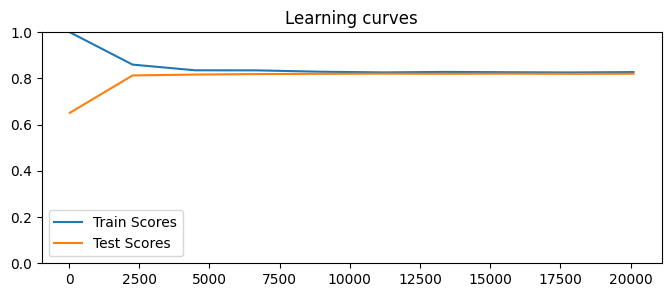

In [161]:
fig = plt.figure(figsize = (8, 3))
ax = plt.gca()

sns.lineplot(
    x = train_sizes,
    y = np.mean(train_scores, axis = 1),
    label = "Train Scores",
    ax = ax
)

sns.lineplot(
    x = train_sizes,
    y = np.mean(test_scores, axis = 1),
    label = "Test Scores",
    ax = ax
)

ax.set_ylim(0, 1)
ax.legend()
ax.set_title("Learning curves")

plt.show()

## Fit the model on the full train set

In [122]:
model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('receptiontransformer',
                                  ReceptionTransformer()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x1555d29e0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x155a0ae30>)]))])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.15022772956819752,
                                            min_samples_leaf=4,
                                            n_estimators=76))])

In [123]:
print(f"-- Fit model on full train set --")
t0 = time()
model.fit(X_train, y_train)
t1 = time() - t0

print("--- Predict ---")
y_pred = model.predict(X_test)
# y_probas = model.predict_proba(X_test)

print("--- Evaluate ---")
accuracy = accuracy_score(y_test, y_pred)
f1_0 = f1_score(y_test, y_pred, pos_label = 0)
f1_1 = f1_score(y_test, y_pred, pos_label = 1)
recall_0 = recall_score(y_test, y_pred, pos_label = 0)
recall_1 = recall_score(y_test, y_pred, pos_label = 1)
precision_0 = precision_score(y_test, y_pred, pos_label = 0)
precision_1 = precision_score(y_test, y_pred, pos_label = 1)

results = {
    "accuracy" : accuracy,
    "f1_0" : f1_0,
    "f1_1" : f1_1,
    "recall_0" : recall_0,
    "recall_1" : recall_1,
    "precision_0" : precision_0,
    "precision_1" : precision_1,
    "training_time" : t1
}

-- Fit model on full train set --
--- Predict ---
--- Evaluate ---


In [124]:
results

{'accuracy': 0.8176682575241063,
 'f1_0': 0.6045627376425856,
 'f1_1': 0.881518987341772,
 'recall_0': 0.8442477876106195,
 'recall_1': 0.8124125058329444,
 'precision_0': 0.47087857847976305,
 'precision_1': 0.9634753735473159,
 'training_time': 86.66669631004333}

## Model Calibration

### Calibrate on validation data

In [130]:
X_cal = calibration_preprocessed.drop(columns = ["success"])
y_cal = calibration_preprocessed["success"]

In [131]:
model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('receptiontransformer',
                                  ReceptionTransformer()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x1555d29e0>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x155a0ae30>)]))])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.15022772956819752,
                                            min_samples_leaf=4,
                                            n_estimators=76))])

In [132]:
# calibrated_model = CalibratedClassifierCV(model_unfit, method = "isotonic")
calibrated_model = CalibratedClassifierCV(model, method = "isotonic", cv = "prefit")
calibrated_model.fit(X_cal, y_cal)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('pipeline',
                                                       Pipeline(steps=[('receptiontransformer',
                                                                        ReceptionTransformer()),
                                                                       ('columntransformer',
                                                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                                                         Pipeline(steps=[('simpleimputer',
                                                                                                                          SimpleImputer()),
                                                                                                                         ('minmaxscaler',
                                                                                                                          MinMaxScaler())]),
                                                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x15...
                                                                                                         Pipeline(steps=[('simpleimputer',
                                                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                                                         ('onehotencoder',
                                                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x155a0ae30>)]))])),
                                                      ('gradientboostingclassifier',
                                                       GradientBoostingClassifier(learning_rate=0.15022772956819752,
                                                                                  min_samples_leaf=4,
                                                                                  n_estimators=76))]),
                       cv='prefit', method='isotonic')

### Check model calibration

In [138]:
y_true = y_test

# Uncalibrated model
y_prob = model.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins = 10)

# Calibrated model
y_prob_cal = calibrated_model.predict_proba(X_test)[:, 1]
prob_true_cal, prob_pred_cal = calibration_curve(y_true, y_prob_cal, n_bins = 10)

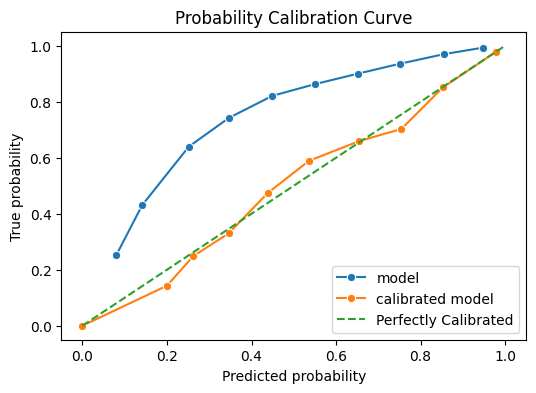

In [139]:
fig = plt.figure(figsize = (6, 4))
ax = plt.gca()

sns.lineplot(
    x = prob_pred,
    y = prob_true,
    label = "model",
    marker = "o",
    ax = ax
)

sns.lineplot(
    x = prob_pred_cal,
    y = prob_true_cal,
    label = "calibrated model",
    marker = "o",
    ax = ax
)

sns.lineplot(
    x = [0, 1], 
    y = [0, 1], 
    linestyle = "--", 
    label = "Perfectly Calibrated"
)

ax.set_xlabel("Predicted probability")
ax.set_ylabel("True probability")

ax.set_title("Probability Calibration Curve")

plt.show()

### Evaluate the calibrated model on the test data

In [140]:
print("--- Predict ---")
y_pred_cal = calibrated_model.predict(X_test)
# y_probas = model.predict_proba(X_test)

print("--- Evaluate ---")
accuracy = accuracy_score(y_test, y_pred_cal)
f1_0 = f1_score(y_test, y_pred_cal, pos_label = 0)
f1_1 = f1_score(y_test, y_pred_cal, pos_label = 1)
recall_0 = recall_score(y_test, y_pred_cal, pos_label = 0)
recall_1 = recall_score(y_test, y_pred_cal, pos_label = 1)
precision_0 = precision_score(y_test, y_pred_cal, pos_label = 0)
precision_1 = precision_score(y_test, y_pred_cal, pos_label = 1)

results = {
    "accuracy" : accuracy,
    "f1_0" : f1_0,
    "f1_1" : f1_1,
    "recall_0" : recall_0,
    "recall_1" : recall_1,
    "precision_0" : precision_0,
    "precision_1" : precision_1,
    "training_time" : t1
}

results

--- Predict ---
--- Evaluate ---


{'accuracy': 0.8775689101003215,
 'f1_0': 0.6208144796380091,
 'f1_1': 0.926999245020036,
 'recall_0': 0.6070796460176991,
 'recall_1': 0.9310545963602427,
 'precision_0': 0.6351851851851852,
 'precision_1': 0.9229790678848155,
 'training_time': 86.66669631004333}

## Save the calibrated model

In [147]:
model_name = f"model_{SIZE}.pkl"
model_path = os.path.join(PROJECT_HOME, "data", "models", model_name)

In [151]:
# Export Model as pickle file
with open(model_path, "wb") as file:
    pickle.dump(calibrated_model, file)

## Load saved model

In [162]:
# Load Model from pickle file
loaded_model = pickle.load(open(model_path,"rb"))
loaded_model.score(X_test, y_test)

0.8775689101003215

In [163]:
loaded_model.predict_proba(sample_demo_pass_preprocessed)

array([[0.00395257, 0.99604743]])

# Demo

In [206]:
random_pass = demo.sample(1)
random_pass

,id,match_date,competition_name,gender,home_team_name,away_team_name,index,period,timestamp,minute,...,pass_goal_assist,pass_through_ball,pass_miscommunication,match_id,pass_no_touch,pass_straight,pass_inswinging,event_uuid,visible_area,freeze_frame
77130,11b62600-8230-4524-9366-24eec9946f1b,2021-06-16,UEFA Euro,male,Turkey,Wales,2779,2,00:33:36.738,78,...,NaN,NaN,NaN,3788755,NaN,NaN,NaN,11b62600-8230-4524-9366-24eec9946f1b,"[72.4471323486493, 80.0, 67.8517843373101, 20....","[{'teammate': True, 'actor': False, 'keeper': ..."


,location_x,location_y,play_pattern_name,pass_angle,pass_height_id,pass_body_part_name,freeze_frame,success
77130,85.7,59.4,From Throw In,-1.674815,1.0,Left Foot,"[{'teammate': True, 'actor': False, 'keeper': ...",0


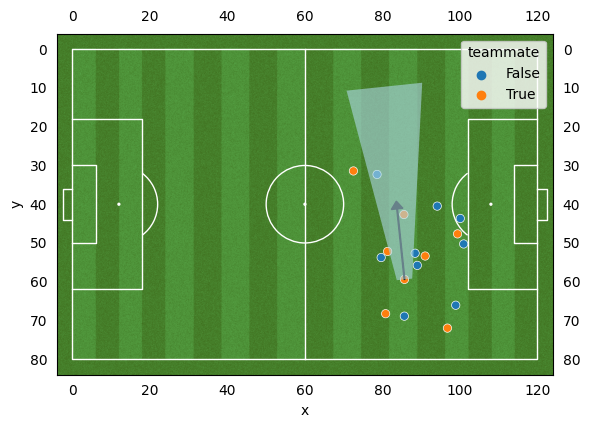

In [207]:
plot_pass(random_pass.iloc[0])
random_pass_preprocessed = get_passes_preprocessed(random_pass)
random_pass_preprocessed

In [208]:
print(f"Actual output: {outcome_map[random_pass_preprocessed['success'].iloc[0]]}")

Actual output: incomplete pass


In [209]:
rand_pred = model.predict(random_pass_preprocessed)
# print(rand_pred)
outcome_map = {0 : "incomplete pass", 1 : "succesful pass"}
print(f"Output prediction: {outcome_map[rand_pred[0]]}")

Output prediction: succesful pass


In [210]:
rand_proba = model.predict_proba(random_pass_preprocessed)
# print(rand_proba)
print(f"Percentage chance of completing the pass: {round(100 * rand_proba[0][1], 1)}%")

Percentage chance of completing the pass: 72.9%
